# Flowers Classification using Resnet50 Model

### Download Flowers dataset

In [0]:
#You can download the data manually as well instead of using 'wget'
!wget http://download.tensorflow.org/example_images/flower_photos.tgz --quiet

In [0]:
#Read the dataset
import tarfile
dataset = tarfile.open('flower_photos.tgz')

In [0]:
#We will build a pandas dataset
import pandas as pd
df = pd.DataFrame(columns=['class','image_file'])

In [0]:
#Run through tarfile members 
for name in dataset.getnames():
    
    tar_mem = dataset.getmember(name)
    
    #Check if it is a file
    if(tar_mem.isfile() and name.endswith('.jpg')):
        #Build directory and class info
        im_dir = name[0:name.rfind('/')]
        im_class = im_dir[im_dir.rfind('/')+1:]
        #Add record to the dataframe
        df.loc[df.shape[0]] = [im_class, name]

In [0]:
#extract data
dataset.extractall(path='')

In [7]:
!ls -l flower_photos

total 612
drwx------ 2 270850 5000  36864 Feb 10  2016 daisy
drwx------ 2 270850 5000  53248 Feb 10  2016 dandelion
-rw-r----- 1 270850 5000 418049 Feb  9  2016 LICENSE.txt
drwx------ 2 270850 5000  36864 Feb 10  2016 roses
drwx------ 2 270850 5000  40960 Feb 10  2016 sunflowers
drwx------ 2 270850 5000  36864 Feb 10  2016 tulips


Create Training & Test Dataset

In [0]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [0]:
train_df.to_csv('flower_photos/train.csv',index=False)
test_df.to_csv('flower_photos/test.csv', index=False)

### Read training and test data

In [0]:
#Read training and test Dataframe
train_df = pd.read_csv('flower_photos/train.csv')
test_df = pd.read_csv('flower_photos/test.csv')

In [45]:
#Check contents
train_df.sample(n=5)

,class,image_file
925,sunflowers,flower_photos/sunflowers/22405887122_75eda1872...
644,sunflowers,flower_photos/sunflowers/151898652_b5f1c70b98_...
2589,roses,flower_photos/roses/23232710191_cc57620cd5.jpg
2294,dandelion,flower_photos/dandelion/4164845062_1fd9b3f3b4.jpg
1876,tulips,flower_photos/tulips/15049902081_dd85361f8c_m.jpg


In [46]:
#Get class names
class_names = train_df['class'].unique().tolist()
print('Flower classes: ', class_names)

Flower classes:  ['tulips', 'daisy', 'sunflowers', 'dandelion', 'roses']


### Build Batch generator (using ImageDataGenerator)

In [0]:
import tensorflow as tf
import numpy as np

In [0]:
#Define some parameters
img_size = 224
img_depth = 3  

Function to normalize image according to Model being used

In [0]:
def normalize_data(img):   
    #Normalize for pretrained model rsnet50
    return tf.keras.applications.resnet50.preprocess_input(img)

Defime ImageDataGenerator for both Training and Test Separately

In [0]:
#Define Training Data Generator with augmentations
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                horizontal_flip=True,
                                                                preprocessing_function=normalize_data) #Normalize the data accordingly

#Define Test Data Generator with NO augmentations
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=normalize_data) #Normalize the data accordingly

Create Data Generators objects for Training and Test

In [52]:
#Training (from dataframe)
train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    x_col='image_file', #File path for image
                                                    y_col='class',           #Class for the image
                                                    target_size=(img_size, img_size), #Image resize dimensions
                                                    batch_size=64)

Found 2936 validated image filenames belonging to 5 classes.


In [53]:
#Test (from dataframe)
test_generator = test_datagen.flow_from_dataframe(test_df,
                                                  x_col='image_file', #File path for image
                                                  y_col='class',           #Class for the image
                                                  target_size=(img_size, img_size), #Image resize dimensions
                                                  batch_size=64)

Found 734 validated image filenames belonging to 5 classes.


ImageDataGenerator has lot of useful features. Learn more about ImageDataGenerator at https://keras.io/preprocessing/image/

In [0]:
#Function to compare the metrics - loss and accuracy for training validation stes over a no of epochs
import matplotlib.pyplot as plt
%matplotlib inline
def plot_metrics(history, ax, fontsize, col1, col2, x_label, y_label, title):
    ax.plot((history.history[col1]))
    ax.plot((history.history[col2]))
    #ax.locator_params(nbins=3)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend(['Training-data', 'Test-data'])
    ax.set_title(title)

## Load pre-trained model Resnet50 model

In [54]:
tf.keras.backend.clear_session()
model = tf.keras.applications.ResNet50(include_top=False, #Do not include classification layer for imagenet
                                       input_shape=(224,224, img_depth),
                                       weights='imagenet')

94773248/94765736 [==============================] - 1s 0us/step


In [55]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [56]:
model.output

<tf.Tensor 'conv5_block3_out/Identity:0' shape=(None, 7, 7, 2048) dtype=float32>

Freeze the layers in Pre-trained model

In [57]:
print("Number of layers in Pre-trained Model:",len(model.layers))

Number of layers in Pre-trained Model: 175


In [0]:
#Set pre-trained model layers to not trainable
for layer in model.layers:
    layer.trainable = False

In [59]:
#Check if layers frozen
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

### Add FC layer for new classes

In [0]:
#get Output layer of Pretrained model
x = model.output

#Global average pool to reduce number of features and Flatten the output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

In [76]:
#Output shape of Global Average Pooling
x

<tf.Tensor 'global_average_pooling2d_2/Identity:0' shape=(None, 2048) dtype=float32>

In [0]:
#Add output layer
prediction = tf.keras.layers.Dense(len(class_names),activation='softmax')(x)

### Building final model for Classification

In [0]:
#Using Keras Model class
final_model = tf.keras.models.Model(inputs=model.input, #Pre-trained model input as input layer
                                    outputs=prediction) #Output layer added

In [0]:
#Compile the model
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [80]:
#How does our overall model looks
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

### Train the model

In [0]:
#Saving the best model using model checkpoint callback
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('flowers_resnet.h5', 
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=1)

In [82]:
history_finalmodel = final_model.fit_generator(train_generator, 
                          epochs=5,
                          steps_per_epoch= 2936//64,
                          validation_data=test_generator,
                          validation_steps = 734//64, 
                          callbacks=[model_checkpoint])

Epoch 1/5
45/45 [==============================] - ETA: 0s - loss: 0.8013 - accuracy: 0.6891
Epoch 00001: val_accuracy improved from -inf to 0.83807, saving model to flowers_resnet.h5
45/45 [==============================] - 46s 1s/step - loss: 0.8013 - accuracy: 0.6891 - val_loss: 0.4351 - val_accuracy: 0.8381
Epoch 2/5
45/45 [==============================] - ETA: 0s - loss: 0.3718 - accuracy: 0.8726
Epoch 00002: val_accuracy improved from 0.83807 to 0.87074, saving model to flowers_resnet.h5
45/45 [==============================] - 45s 1s/step - loss: 0.3718 - accuracy: 0.8726 - val_loss: 0.3442 - val_accuracy: 0.8707
Epoch 3/5
45/45 [==============================] - ETA: 0s - loss: 0.3128 - accuracy: 0.8865
Epoch 00003: val_accuracy improved from 0.87074 to 0.89205, saving model to flowers_resnet.h5
45/45 [==============================] - 45s 999ms/step - loss: 0.3128 - accuracy: 0.8865 - val_loss: 0.2955 - val_accuracy: 0.8920
Epoch 4/5
45/45 [==============================] - E

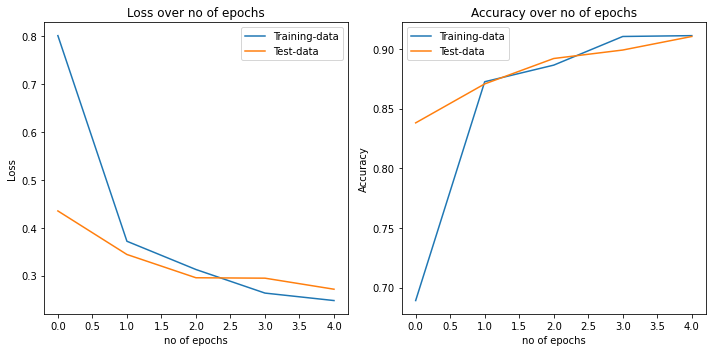

In [83]:
#Plot showing metrics comaparision
plt.close('all')
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
plot_metrics(history_finalmodel, ax1, 30, 'loss', 'val_loss', 'no of epochs', 'Loss', 'Loss over no of epochs')
plot_metrics(history_finalmodel, ax2, 30, 'accuracy', 'val_accuracy', 'no of epochs', 'Accuracy', 'Accuracy over no of epochs')
plt.tight_layout()
plt.show()

#### Training accuracy and validation accuracy both are 91%

In [84]:
#Lets train for 5 more steps
history_finalmodel = final_model.fit_generator(train_generator, 
                          epochs=10,
                          initial_epoch=5,
                          steps_per_epoch= 2936//64,
                          validation_data=test_generator,
                          validation_steps = 734//64, 
                          callbacks=[model_checkpoint])

Epoch 6/10
45/45 [==============================] - ETA: 0s - loss: 0.2047 - accuracy: 0.9318
Epoch 00006: val_accuracy did not improve from 0.91051
45/45 [==============================] - 44s 985ms/step - loss: 0.2047 - accuracy: 0.9318 - val_loss: 0.2514 - val_accuracy: 0.9034
Epoch 7/10
45/45 [==============================] - ETA: 0s - loss: 0.1963 - accuracy: 0.9318
Epoch 00007: val_accuracy did not improve from 0.91051
45/45 [==============================] - 44s 982ms/step - loss: 0.1963 - accuracy: 0.9318 - val_loss: 0.2341 - val_accuracy: 0.9091
Epoch 8/10
45/45 [==============================] - ETA: 0s - loss: 0.1829 - accuracy: 0.9352
Epoch 00008: val_accuracy did not improve from 0.91051
45/45 [==============================] - 44s 984ms/step - loss: 0.1829 - accuracy: 0.9352 - val_loss: 0.2446 - val_accuracy: 0.9077
Epoch 9/10
45/45 [==============================] - ETA: 0s - loss: 0.1735 - accuracy: 0.9429
Epoch 00009: val_accuracy improved from 0.91051 to 0.91193, sav

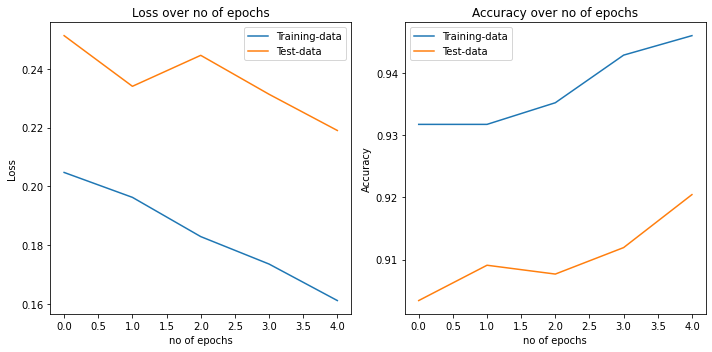

In [85]:
#Plot showing metrics comaparision
plt.close('all')
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
plot_metrics(history_finalmodel, ax1, 30, 'loss', 'val_loss', 'no of epochs', 'Loss', 'Loss over no of epochs')
plot_metrics(history_finalmodel, ax2, 30, 'accuracy', 'val_accuracy', 'no of epochs', 'Accuracy', 'Accuracy over no of epochs')
plt.tight_layout()
plt.show()

#### Training accuracy is 95% and validation accuracy is 92%

### Unfreeze some of Trained Layers in ResNet

At this point, our model is overfit. How do we improve our model when using Transfer Learning. Here are some approaches to try:

1. Unfreeze lesser number of layers (fewer parameters to train)
2. Train unfrozen layer with smaller learning rate (avoiding big changes to weights)
3. Use Dropout before output layer

In [86]:
print("Number of layers in Pre-trained Model:",len(model.layers))

Number of layers in Pre-trained Model: 175


Let's unfreeze 10% at the end (which have high end features more specific to ImageNet)

In [0]:
#Unfreezing all layers after layer# 158
for layer in model.layers[158:]:
    layer.trainable = True    

In [88]:
#We will need to recompile the model
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [89]:
#Lets train for 10 steps
history_finalmodel = final_model.fit_generator(train_generator, 
                          epochs=20,
                          initial_epoch=10,
                          steps_per_epoch= 2936//64,
                          validation_data=test_generator,
                          validation_steps = 734//64, 
                          callbacks=[model_checkpoint])

Epoch 11/20
45/45 [==============================] - ETA: 0s - loss: 0.2735 - accuracy: 0.9185
Epoch 00011: val_accuracy did not improve from 0.92045
45/45 [==============================] - 46s 1s/step - loss: 0.2735 - accuracy: 0.9185 - val_loss: 55.8485 - val_accuracy: 0.4332
Epoch 12/20
45/45 [==============================] - ETA: 0s - loss: 0.1491 - accuracy: 0.9523
Epoch 00012: val_accuracy did not improve from 0.92045
45/45 [==============================] - 46s 1s/step - loss: 0.1491 - accuracy: 0.9523 - val_loss: 0.8367 - val_accuracy: 0.8821
Epoch 13/20
45/45 [==============================] - ETA: 0s - loss: 0.0789 - accuracy: 0.9781
Epoch 00013: val_accuracy did not improve from 0.92045
45/45 [==============================] - 45s 1s/step - loss: 0.0789 - accuracy: 0.9781 - val_loss: 0.5258 - val_accuracy: 0.8935
Epoch 14/20
45/45 [==============================] - ETA: 0s - loss: 0.0496 - accuracy: 0.9850
Epoch 00014: val_accuracy did not improve from 0.92045
45/45 [=====

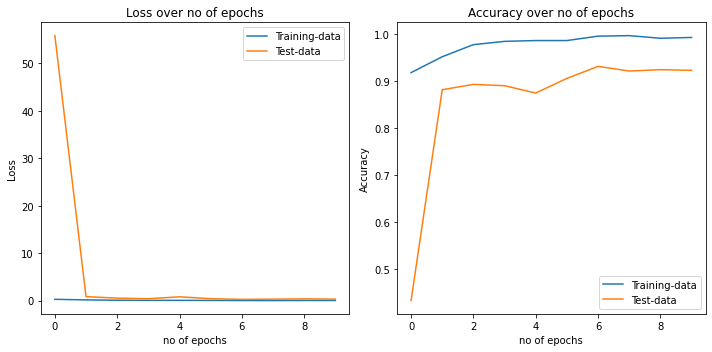

In [90]:
#Plot showing metrics comaparision
plt.close('all')
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
plot_metrics(history_finalmodel, ax1, 30, 'loss', 'val_loss', 'no of epochs', 'Loss', 'Loss over no of epochs')
plot_metrics(history_finalmodel, ax2, 30, 'accuracy', 'val_accuracy', 'no of epochs', 'Accuracy', 'Accuracy over no of epochs')
plt.tight_layout()
plt.show()

### Training accuracy is 99% and Validation Accuracy is 93%.There is only a slight increase in Validation accuracy.

In [91]:
#Lets train for 10 more steps
history_finalmodel = final_model.fit_generator(train_generator, 
                          epochs=30,
                          initial_epoch=20,
                          steps_per_epoch= 2936//64,
                          validation_data=test_generator,
                          validation_steps = 734//64, 
                          callbacks=[model_checkpoint])

Epoch 21/30
45/45 [==============================] - ETA: 0s - loss: 0.0192 - accuracy: 0.9937
Epoch 00021: val_accuracy did not improve from 0.93182
45/45 [==============================] - 44s 973ms/step - loss: 0.0192 - accuracy: 0.9937 - val_loss: 0.3250 - val_accuracy: 0.9219
Epoch 22/30
45/45 [==============================] - ETA: 0s - loss: 0.0239 - accuracy: 0.9937
Epoch 00022: val_accuracy did not improve from 0.93182
45/45 [==============================] - 45s 990ms/step - loss: 0.0239 - accuracy: 0.9937 - val_loss: 0.2952 - val_accuracy: 0.9318
Epoch 23/30
45/45 [==============================] - ETA: 0s - loss: 0.0164 - accuracy: 0.9962
Epoch 00023: val_accuracy did not improve from 0.93182
45/45 [==============================] - 44s 980ms/step - loss: 0.0164 - accuracy: 0.9962 - val_loss: 0.3067 - val_accuracy: 0.9190
Epoch 24/30
45/45 [==============================] - ETA: 0s - loss: 0.0182 - accuracy: 0.9958
Epoch 00024: val_accuracy did not improve from 0.93182
45/4

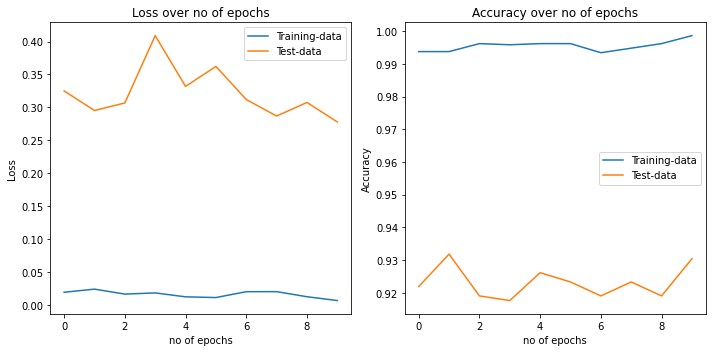

In [92]:
#Plot showing metrics comaparision
plt.close('all')
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
plot_metrics(history_finalmodel, ax1, 30, 'loss', 'val_loss', 'no of epochs', 'Loss', 'Loss over no of epochs')
plot_metrics(history_finalmodel, ax2, 30, 'accuracy', 'val_accuracy', 'no of epochs', 'Accuracy', 'Accuracy over no of epochs')
plt.tight_layout()
plt.show()

### Training accuracy is 99% and Validation Accuracy is 93%.There is no improvement in validation accuracy and the model is overfitting